In [4]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk

In [5]:
df=pd.read_csv("datasets/tweets.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          1224 non-null   object
 1   keyword       1224 non-null   object
 2   country       1224 non-null   object
 3   date_created  1224 non-null   object
dtypes: object(4)
memory usage: 38.4+ KB


In [6]:
df.isna().any()

text            False
keyword         False
country         False
date_created    False
dtype: bool

In [7]:
df.describe()

,text,keyword,country,date_created
count,1224,1224,1224,1224
unique,939,30,8,15
top,rt masternobody unlearning toxic patterns beco...,fish kills,None,2022-05-24
freq,7,139,1207,231


In [8]:
df.drop_duplicates()

,text,keyword,country,date_created
0,spring time blooms many kinds including harmfu...,cyanotoxin,None,2022-04-13
1,missed thread huge environmental benefits uncr...,water quality,None,2022-04-18
2,powrebecca conservatives timfarron itvborder ...,water quality,None,2022-04-18
3,takes football twitter absolutely laughable ri...,water quality,None,2022-04-18
4,firaszahabi fast 168 loads good quality water ...,water quality,None,2022-04-18
...,...,...,...,...
1092,rt intoashtef pay attention toxic words people...,toxic,None,2022-05-25
1118,immoralnra ownedgop scum howling jesusampinvok...,mass mortality,None,2022-05-25
1119,schipperlisa lot doomism seem come people affe...,mass mortality,None,2022-05-25
1172,talledcombs go directly hell man novelty fish ...,fish kills,None,2022-05-25


In [ ]:
sns.barplot(x='keyword',y='created_at',data=df,palette='summer')

<FreqDist with 7986 samples and 23473 outcomes>


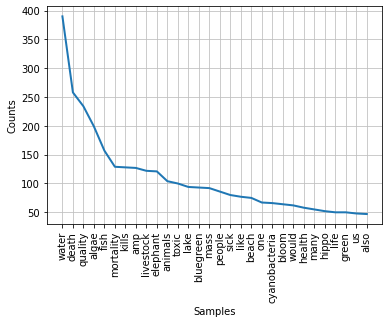

In [10]:
all_text = ''

for index, row in df.iterrows():
    all_text = all_text + row['text']

tokenized_word = word_tokenize(all_text)

fdist = FreqDist(tokenized_word)
print(fdist)
fdist.most_common(2)

fdist.plot(30, cumulative=False)
plt.show()

In [12]:
tokenized_word=word_tokenize(df['text'])
print(tokenized_word)

fdist = FreqDist(tokenized_word)
print(fdist)
fdist.most_common(2)

fdist.plot(30,cumulative=False)
plt.show()

TypeError: expected string or bytes-like object

Average word count for the tweets

In [13]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print(df['word_count'].mean())

20.154411764705884


Average number of characters in tweet

In [14]:
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
print(df['char_count'].mean())

156.45424836601308


In [15]:
from sklearn.model_selection import train_test_split

#Splitting test set and training set
X_train, X_test, y_train, y_test = train_test_split(df["text"],df["keyword"],test_size=0.2,shuffle=True)
#Running word2vec
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

Code vectorization using bag of words

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
            return self

    def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)
                for words in X
            ])

model = Word2Vec(df['text'], min_count=1)   
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

df['text_tok']=[nltk.word_tokenize(i) for i in df['text']]
model = Word2Vec(df['text_tok'],min_count=1)     
modelw = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

#Fitting Logistic Regression
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict,zero_division=1))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='your_label')
roc_auc = auc(fpr, tpr)
print('auc:', roc_auc)

                                precision    recall  f1-score   support

              algae cyanotoxin       1.00      0.00      0.00         1
           beach water quality       0.80      0.73      0.76        11
              blue green algae       0.63      0.80      0.71        15
      blue green algae animals       0.00      0.00      0.00         1
        blue green algae water       0.00      0.00      0.00         7
blue green algae water quality       0.00      1.00      0.00         0
            cyanobacteria pond       0.00      0.00      0.00         3
           cyanobacteria water       0.50      0.40      0.44         5
                    cyanotoxin       0.00      0.00      0.00         1
                elephant death       0.92      0.85      0.88        13
                 elephant sick       0.88      1.00      0.93        14
                    fish kills       0.94      1.00      0.97        31
                 flamingo sick       1.00      0.00      0.00  

C:\Users\ioana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [ ]:
X_test = df['text'] 
X_vector = tfidf_vectorizer.transform(X_test)

y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df['predict_prob']= y_prob
df['keyword']= y_predict
final=df[['text','keyword']].reset_index(drop=True)
print(final.head())

                                                text        keyword
0  spring time blooms many kinds including harmfu...     cyanotoxin
1  missed thread huge environmental benefits uncr...  water quality
2  powrebecca conservatives timfarron itvborder  ...  water quality
3  takes football twitter absolutely laughable ri...  water quality
4  firaszahabi fast 168 loads good quality water ...  water quality


In [19]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

<AxesSubplot:>

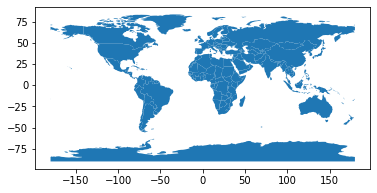

In [20]:
world.plot()

In [ ]:
import geopandas as gpd
from descartes import PolygonPatch

def plotCountryPatch(axes, country_name, fcolor):
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  #geointerface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

ax2 = world.plot(figsize=(8,4), edgecolor=u'gray')

for index, row in df.iterrows():
    df.head()
    print(row['country'])
    if row['country'] != "None" or row['country'] == 'United States': plotCountryPatch(ax2, row['country'], 'green')


<AxesSubplot:>

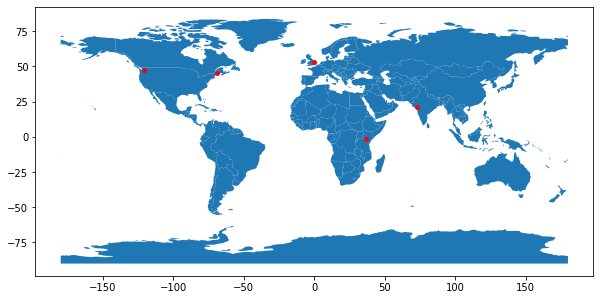

In [31]:
from shapely.geometry import Point
from geopandas import GeoDataFrame

long = df['coordinates'][0]
lat = df['coordinates'][1]
geometry = [Point(xy) for xy in zip(long, lat)]
gdf = GeoDataFrame(geometry=geometry)   

gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

In [ ]:
from textblob import TextBlob

def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

def getPolarity(review):
    return TextBlob(review).sentiment.polarity

def analysis(score):
    if score < 0: return 'Negative'
    elif score == 0: return 'Neutral'
    else: return 'Positive'


df['Polarity'] = df['text'].apply(getPolarity) 
df['Sentiment'] = df['Polarity'].apply(analysis)
df.head()

,text,keyword,country,date_created,Polarity,Sentiment
0,spring time blooms many kinds including harmfu...,cyanotoxin,None,2022-04-13,0.350000,Positive
1,missed thread huge environmental benefits uncr...,water quality,None,2022-04-18,0.200000,Positive
2,powrebecca conservatives timfarron itvborder ...,water quality,None,2022-04-18,0.000000,Neutral
3,takes football twitter absolutely laughable ri...,water quality,None,2022-04-18,-0.043333,Negative
4,firaszahabi fast 168 loads good quality water ...,water quality,None,2022-04-18,0.350000,Positive


In [ ]:
res = df.Analysis.value_counts()
res

Positive    185
Neutral     127
Negative    125
Name: Analysis, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

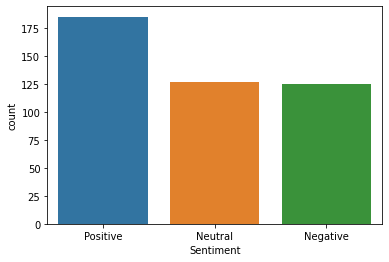

In [ ]:
sns.countplot(x = "Sentiment", data = df)